In [1]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt 

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn


from pytvision.transforms.aumentation import  ObjectImageMetadataTransform
from pytvision.transforms import transforms as mtrans

sys.path.append('../')
import torch.nn.functional as TF
from torchlib.transforms import functional as F
from torchlib.datasets.synthetic_fer  import SyntheticFaceDataset
from torchlib.datasets.factory  import FactoryDataset
from torchlib.datasets.datasets import Dataset

from torchlib.attentionnet import AttentionNeuralNet



In [2]:
!ls ../netruns/

attention_atentionresnet34_mcedice_adam_coco_001
attention_atentionresnet34_mcedice_adam_coco_002
attention_atentionresnet34_mcedice_adam_coco_003
attention_atentionresnet34_mcedice_adam_coco_bu3dfe_004
attention_atentionresnet34_mcedice_adam_coco_bu3dfe_005
attention_atentionresnet34_mcedice_adam_coco_bu3dfe_006
attention_atentionresnet34_mcedice_adam_coco_bu3dfe_007
attention_atentionresnet34_mcedice_adam_coco_dim64_bu3dfe_008
attention_atentionresnet34_mcedice_adam_coco_dim64_bu3dfe_009
attention_atentionresnet34_mcedice_adam_coco_dim64_preactresnet_bu3dfe_10
attention_atentionresnet34_mcedice_adam_coco_ferblack_004
attention_atentionresnet34_mcedice_sgd_coco_bu3dfe_007
attention_unetresnet_mcedice_adam_coco_001
newdataset
newdataset.tar.gz


In [3]:
project          = '../netruns'
name             = 'attention_atentionresnet34_mcedice_adam_coco_dim64_preactresnet_bu3dfe_10'
pathnamedataset  = '~/.datasets'
pathmodel        = os.path.join( project, name, 'models/model_best.pth.tar' )
pathproject      = os.path.join( project, name )
batch_size       = 2
workers          = 1
cuda             = False
parallel         = False
gpu              = 1
seed             = 1
imsize           = 128

In [4]:
# Load dataset
print('>> Load dataset ...')
namedataset = FactoryDataset.ck
subset = FactoryDataset.training

dataset = Dataset(    
    data=FactoryDataset.factory(
        pathname=pathnamedataset, 
        name=namedataset, 
        subset=subset, 
        #transform=train_transform, 
        download=True 
    ),
    num_channels=3,
    transform=transforms.Compose([
            
            mtrans.ToResize( (128,128), resize_mode='square' ),
            mtrans.ToPad(h_pad=10,w_pad=10),
            mtrans.ToResize( (128,128), resize_mode='square' ),
        
            #mtrans.RandomCrop( (255,255), limit=50, padding_mode=cv2.BORDER_CONSTANT  ),
            #mtrans.ToResizeUNetFoV(imsize, cv2.BORDER_REFLECT_101),
            mtrans.ToTensor(),
            mtrans.ToMeanNormalization( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )
            #mtrans.ToNormalization(),
            ])
    )

print(len(dataset))
print( dataset.classes )
print( dataset.data.class_to_idx )


>> Load dataset ...
358
[0 1 2 3 4 5 6 7]
{'Neutral - NE': 0, 'Happiness - HA': 1, 'Surprise - SU': 2, 'Sadness - SA': 3, 'Anger - AN': 4, 'Disgust - DI': 5, 'Fear - FR': 6, 'Contempt - CO': 7}


In [27]:
import pandas as pd
ids = np.array(dataset.data.iactor).astype( np.uint8 )
df = pd.DataFrame( ids )
df.to_csv( 'ids.csv' , index=False, encoding='utf-8') 


In [5]:
# load model
print('>> Load model ...')

net = AttentionNeuralNet( 
    patchproject=project, 
    nameproject=name, 
    no_cuda=cuda, 
    parallel=parallel, 
    seed=seed, 
    gpu=gpu 
    )

if net.load( pathmodel ) is not True:
    assert(False)

Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


>> Load model ...
=> loading checkpoint '../netruns/attention_atentionresnet34_mcedice_adam_coco_dim64_preactresnet_bu3dfe_10/models/model_best.pth.tar'
=> loaded checkpoint for atentionresnet34 arch!


0.0 1.0


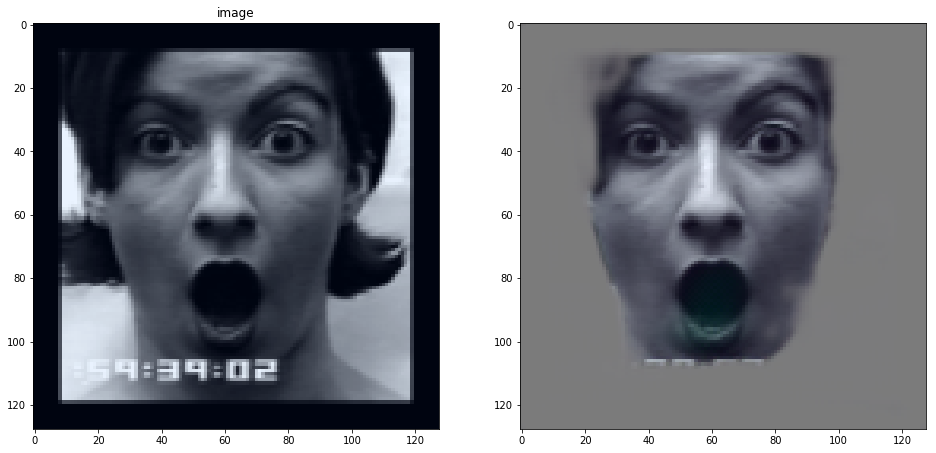

In [13]:
def norm(x):
    x = x-x.min()
    x = x / x.max()
    return x

   
idx = 1
sample = dataset[ idx ]    
image = sample['image'].unsqueeze(0)
label = sample['label'].argmax()
#image = F.fliplr( image )

z, y_lab_hat, att = net( image )

att = att.data.cpu().numpy().transpose(2,3,1,0)[...,0]
# att = norm(att)

image = image.data.cpu().numpy().transpose(2,3,1,0)[...,0]
y_lab_hat = y_lab_hat.argmax()

image = norm(image)
print(image.min(), image.max() )

plt.figure( figsize=(16,8))
plt.subplot(121)
plt.imshow( image )
plt.title('image')
plt.subplot(122)
plt.imshow( norm(att) )  

plt.show()



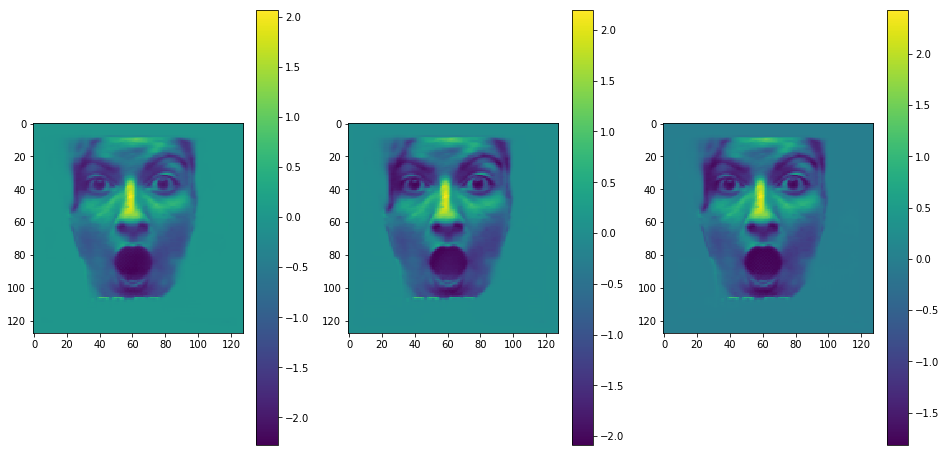

In [15]:
plt.figure( figsize=(16,8))
plt.subplot(131)
plt.imshow( att[:,:,0]  )
plt.colorbar()
plt.subplot(132)
plt.imshow( att[:,:,1] )
plt.colorbar()
plt.subplot(133)
plt.imshow( att[:,:,2] )
plt.colorbar()
plt.show()

(128, 128)
(128, 128)


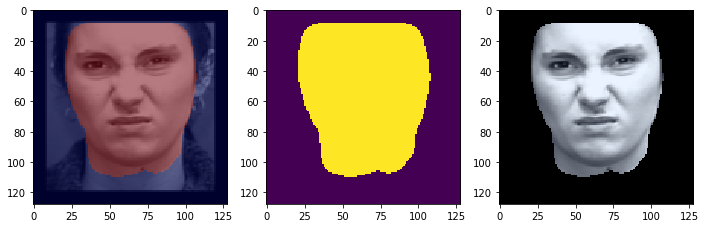

In [139]:
import skimage.morphology as morph
import scipy.ndimage as ndi

pathnewdataset='../netruns/newdataset'

mask = pred 
struct_el = morph.disk(11)
mask = ndi.morphology.binary_fill_holes( mask )
# mask = morph.binary_closing(mask, selem=struct_el)
mask = morph.binary_opening(mask, selem=struct_el)

mask_ex = np.stack( (mask,mask,mask),axis=2 )
im_mask = (mask_ex)*image + (1-mask_ex)*np.zeros_like(image)

print(mask.shape)
print(pred.shape)

# cv2.imwrite('{}/{:06d}_{}.png'.format(pathnewdataset,idx,label), (im_mask*255.0).astype(np.uint8) )

plt.figure(figsize=(16,8))
plt.subplot(141)
plt.imshow(image)
plt.imshow(mask, cmap='seismic', alpha=0.5)
plt.subplot(142)
plt.imshow(mask)
plt.subplot(143)
plt.imshow(im_mask)
plt.show()

